In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 818 kB/s 


In [ ]:
from utils import *
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
import numpy as np
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [ ]:
#Importação do arquivo 'csv' para o python utilizando a biblioteca pandas

X_col = 'review_text'
y_col = 'polarity'

ds = pd.read_csv('olist.csv', delimiter=',')

#Remoçao das linhas com valores NaN e eliminação de exemplos positivos para balancear a base de dados
ds = ds.dropna()
ds_remove = ds.loc[(ds['rating'] == 4)]
ds = ds.drop(ds_remove.index)


X = ds.loc[:, X_col].values
y = ds.loc[:, y_col].values

In [ ]:
#Tokenização dos textos
preprocessamento = PreProcessamento()
X = preprocessamento.tokenize(X)

In [ ]:
#Utilizar a biblioteca nltk para baixar a lista de stopwords em portugues
nltk.download('stopwords')
stopwords_ = stopwords.words('portuguese')

#Remoção da palavra 'não' da lista de stopwords, por apresentar relevância nessa classificação.
stopwords_.remove('não')

#Adicionar stopwords de acordo com as caracteristicas da base
stopword_list=[]
stopword_list.append('é')
stopword_list.append('vou')
stopword_list.append('que')

#Adiciona os valores para a lista
stopword_list.extend(stopwords_)

#Remove eventuais valores duplicados
stopword_list = list(set(stopword_list))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Remove as stopwords
X = preprocessamento.remove_stopwords(X,stopword_list)

In [ ]:
#Definição do dicionário para realizar standartization 
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 
'vocês','tb': 'também', 'tbm': 'também', 
'obg': 'obrigado', 'gnt': 'gente', 'q': 
'que', 'n': 'não', 'cmg': 'comigo', 'p': 
'para', 'ta': 'está', 
'to': 'estou', 'vdd': 'verdade', 'nao': 'não'}

##X = preprocessamento.apply_standardization(X, std_list)
X = preprocessamento.apply_stemmer(X)

#Untokenização das variáveis
X = preprocessamento.untokenize_text(X)

In [ ]:
#Realiza a vetorização (one-hot encoding)
#Opção de realizar utilizando bi-gram ou não

vectorizer = CountVectorizer()
##vectorizer = CountVectorizer(ngram_range=(2, 2))


#Define o número de features
vectorizer.max_features = 5000

X = vectorizer.fit_transform(X)
X = X.toarray()

#Obtem as palavras que serão usadas como features
features = list(vectorizer.get_feature_names_out())

#Utilização do método TF-idf para pesar a relevância das palavras no documento
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)
X = X.toarray()

In [ ]:
#Separa a base de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

In [ ]:
#Utiliza a biblioteca random forest

rfc = RandomForestClassifier(n_estimators=100, random_state=0)

#Treinamento do modelo

rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
#Realiza as previsões na base de teste
y_pred = rfc.predict(X_test)

#Analise dos resultados
evaluation = Evaluation()

matrix = metrics.confusion_matrix(y_test, y_pred)

acc = evaluation.get_accuracy(matrix)
f_score = evaluation.f_score(matrix)
print(acc)
print(f_score)

0.9420385779122542
0.9201302931596091


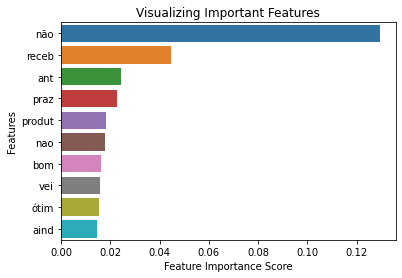

In [ ]:
#Construção do gráfico com a importância das features
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

#Transformar o código das features em palavras
indice = list(feature_scores.index)
palavras = []
for i in indice:
    palavras.append(features[i])

# Plotando o gráfico
sns.barplot(x=feature_scores[:10], y=palavras[:10])

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

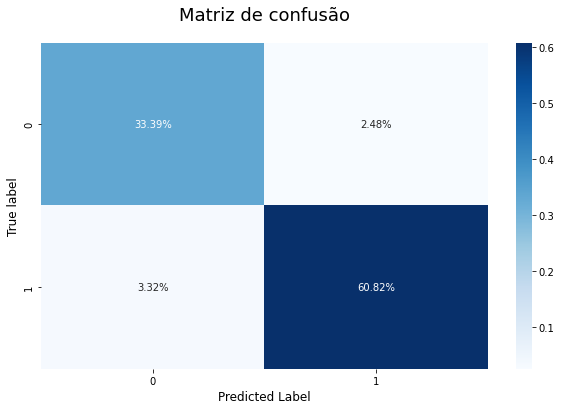

In [ ]:
#Define o plot
fig, ax = plt.subplots(figsize=(10,6))

#Adiciona o titulo para o mapa de calor
title = "Matriz de confusão"

plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

##sns.heatmap(matrix, annot=True, fmt="",linewidths=0.30,ax=ax)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax)
ax.set_ylabel("True label",fontsize=12)
ax.set_xlabel("Predicted Label",fontsize=12)
plt.show()